# Preprocessing intracranial EEG using MNE-python

*NeuroHackademy 2023*  
[Liberty Hamilton, PhD](https://slhs.utexas.edu/research/hamilton-lab)  
Assistant Professor, Department of Speech, Language, and Hearing Sciences and  
Department of Neurology  
The University of Texas at Austin  

This notebook will show you how to preprocess intracranial EEG using MNE-python. This uses a freely available iEEG dataset on audiovisual movie watching from [Julia Berezutskaya, available on OpenNeuro.org](https://openneuro.org/datasets/ds003688/versions/1.0.7/metadata). This notebook mostly covers the basics of how to look at iEEG data, and my tutorial will discuss how to find and identify artifacts. The method of high gamma extraction is identical to that used in [Hamilton et al. 2018](https://doi.org/10.1016/j.cub.2018.04.033) and [Hamilton et al. 2021](https://doi.org/10.1016/j.cell.2021.07.019).

## Python libraries used in this tutorial

* MNE-python
* numpy
* pandas
* matplotlib

## What you will do in this tutorial

* Load an iEEG dataset in MNE-python
* Compare iEEG dataset with BIDs metadata vs. without so you know what to do if you encounter data without this info
* Plot the power spectrum of the data to check for bad channels and compare channel types
* Re-reference the data according to different reference schemes
* Compute the high gamma analytic amplitude of the signal
* Plot evoked data

In [1]:
#!pip install mne_bids
#!pip install ipympl
#!pip install pybids
%matplotlib notebook

import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
from mne_bids.path import get_bids_path_from_fname
from bids import BIDSLayout
from ecog_preproc_utils import transformData
import bids 

#%matplotlib tk

## Download BIDS iEEG dataset

Here we will download an example iEEG dataset from [Berezutskaya et al.  Open multimodal iEEG-fMRI dataset from naturalistic stimulation with a short audiovisual film.](https://openneuro.org/datasets/ds003688/versions/1.0.7/metadata). Here I am showing data from `sub-06`, `iemu` data only. The whole dataset is rather large (15 GB), so if you prefer to download just this session you can do that.

To show the capabilities of BIDS and contrast to when we don't use BIDS, we'll load the data in two ways. The data structure using BIDS will be called `raw`, the data structure without BIDS will be `raw_nobids`.

In [2]:
# Change these variables to work for your block
subj = '06'
sess = 'iemu'
task = 'film'
acq = 'clinical'
run = 1

In [149]:
# Change the data directory below to where your data are located. 
parent_dir = '/home/jovyan/shared/ds003688/'
ieeg_dir = f'{parent_dir}/sub-{subj}/ses-{sess}/ieeg/'
channel_path = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_channels.tsv'
raw_path = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_ieeg.vhdr'

bids_path = get_bids_path_from_fname(raw_path)
base_name = os.path.basename(raw_path).split('.')[0]

## BIDS layout

We can use `pybids` to show a little bit about the files in this BIDS dataset. We won't get as much into this, but if you'd like to try this tutorial on your own you may wish to delve into this more.

In [150]:
layout = BIDSLayout(parent_dir)

In [151]:
layout.get_tasks()

['film', 'rest']

In [152]:
all_files = layout.get()
print("There are {} files in the layout.".format(len(all_files)))
print("\nThe first 10 files are:")
all_files[:10]

There are 1207 files in the layout.

The first 10 files are:


[<BIDSFile filename='/Users/liberty/Documents/Austin/code/nh23-curriculum/hamilton-ieeg-preprocessing/data/ds003688-download/CHANGES'>,
 <BIDSJSONFile filename='/Users/liberty/Documents/Austin/code/nh23-curriculum/hamilton-ieeg-preprocessing/data/ds003688-download/dataset_description.json'>,
 <BIDSJSONFile filename='/Users/liberty/Documents/Austin/code/nh23-curriculum/hamilton-ieeg-preprocessing/data/ds003688-download/participants.json'>,
 <BIDSDataFile filename='/Users/liberty/Documents/Austin/code/nh23-curriculum/hamilton-ieeg-preprocessing/data/ds003688-download/participants.tsv'>,
 <BIDSFile filename='/Users/liberty/Documents/Austin/code/nh23-curriculum/hamilton-ieeg-preprocessing/data/ds003688-download/README'>,
 <BIDSJSONFile filename='/Users/liberty/Documents/Austin/code/nh23-curriculum/hamilton-ieeg-preprocessing/data/ds003688-download/sub-01/ses-iemu/ieeg/sub-01_ses-iemu_acq-clinical_coordsystem.json'>,
 <BIDSDataFile filename='/Users/liberty/Documents/Austin/code/nh23-curricu

In [153]:
print_dir_tree(parent_dir, max_depth=3)

|ds003688-download/
|--- .DS_Store
|--- .bidsignore
|--- .gitattributes
|--- CHANGES
|--- README
|--- annex-uuid
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- .datalad/
|------ .gitattributes
|------ config
|--- stimuli/
|------ .DS_Store
|------ annotations/
|--------- .DS_Store
|--------- sound/
|--------- video/
|--- sub-01/
|------ sub-01_sessions.json
|------ sub-01_sessions.tsv
|------ ses-iemu/
|--------- sub-01_ses-iemu_scans.tsv
|--------- ieeg/
|------ ses-mri3t/
|--------- sub-01_ses-mri3t_scans.tsv
|--------- anat/
|--- sub-02/
|------ sub-02_sessions.json
|------ sub-02_sessions.tsv
|------ ses-iemu/
|--------- sub-02_ses-iemu_scans.tsv
|--------- ieeg/
|------ ses-mri3t/
|--------- sub-02_ses-mri3t_scans.tsv
|--------- anat/
|--- sub-03/
|------ sub-03_sessions.json
|------ sub-03_sessions.tsv
|------ ses-iemu/
|--------- sub-03_ses-iemu_scans.tsv
|--------- ieeg/
|------ ses-mri3t/
|--------- sub-03_ses-mri3t_scans.tsv
|--------- anat/
|

## Let's load some iEEG data!

In [154]:
# Read data and extract parameters from BIDS files
raw = read_raw_bids(bids_path, verbose=True)

Extracting parameters from data/ds003688-download/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...
Reading events from data/ds003688-download/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_task-film_run-1_events.tsv.
Reading channel info from data/ds003688-download/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_task-film_acq-clinical_run-1_channels.tsv.
Reading electrode coords from data/ds003688-download/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_acq-clinical_electrodes.tsv.


/var/folders/3f/h3pnh73d18ldksmkrp_fvtk00000gn/T/ipykernel_47353/531307012.py:2: RuntimeWarning: The unit for channel(s) R1+, R2+, R3+ has changed from V to NA.
  raw = read_raw_bids(bids_path, verbose=True)


In [155]:
# Read the data assuming we didn't have the BIDS structure in place
raw_nobids = mne.io.read_raw_brainvision(raw_path, preload=True)

Extracting parameters from data/ds003688-download//sub-06/ses-iemu/ieeg//sub-06_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 203145  =      0.000 ...   396.768 secs...


In [156]:
raw.load_data()
raw.info

Reading 0 ... 203145  =      0.000 ...   396.768 secs...


<Info | 13 non-empty values
 bads: 3 items (P48, MKR1+, T03)
 ch_names: P01, P02, P03, P04, P05, P06, P07, P08, P09, P10, P11, P12, P13, ...
 chs: 104 ECoG, 2 Stimulus, 1 ECG, 3 misc, 2 EMG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 104 items (104 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 256.0 Hz
 meas_date: 1900-01-03 11:57:13 UTC
 nchan: 112
 projs: []
 sfreq: 512.0 Hz
 subject_info: 10 items (dict)
>

In [157]:
raw.info['ch_names']

['P01',
 'P02',
 'P03',
 'P04',
 'P05',
 'P06',
 'P07',
 'P08',
 'P09',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17',
 'P18',
 'P19',
 'P20',
 'P21',
 'P22',
 'P23',
 'P24',
 'P25',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P32',
 'P33',
 'P34',
 'P35',
 'P36',
 'P37',
 'P38',
 'P39',
 'P40',
 'P41',
 'P42',
 'P43',
 'P44',
 'P45',
 'P46',
 'P47',
 'P48',
 'Fb49',
 'Fb50',
 'Fb51',
 'Fb52',
 'Fb53',
 'Fb54',
 'Fb55',
 'Fb56',
 'Fb57',
 'Fb58',
 'Fb59',
 'Fb60',
 'Fb61',
 'Fb62',
 'Fb63',
 'Fb64',
 'MKR1+',
 'vT1',
 'vT2',
 'vT3',
 'vT4',
 'vT5',
 'vT6',
 'vT7',
 'vT8',
 'sT1',
 'sT2',
 'sT3',
 'sT4',
 'sT5',
 'sT6',
 'sT7',
 'sT8',
 'T01',
 'T02',
 'T03',
 'T04',
 'T05',
 'T06',
 'T07',
 'T08',
 'ECG+',
 'R1+',
 'R2+',
 'R3+',
 'F01',
 'F02',
 'F03',
 'F04',
 'F05',
 'F06',
 'F07',
 'F08',
 'F09',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'thor+',
 'abdo+',
 'MKR2+']

## Plot the power spectrum

Now we will plot the power spectrum of the signal to give us an idea of the signals we're getting. Bad channels (or channels that are not EEG/ECoG) will often have a very different power spectrum than the good channels. These will show up as highly outside the range of the other channels (either flat, or much higher/lower power).

Effective window size : 4.000 (s)


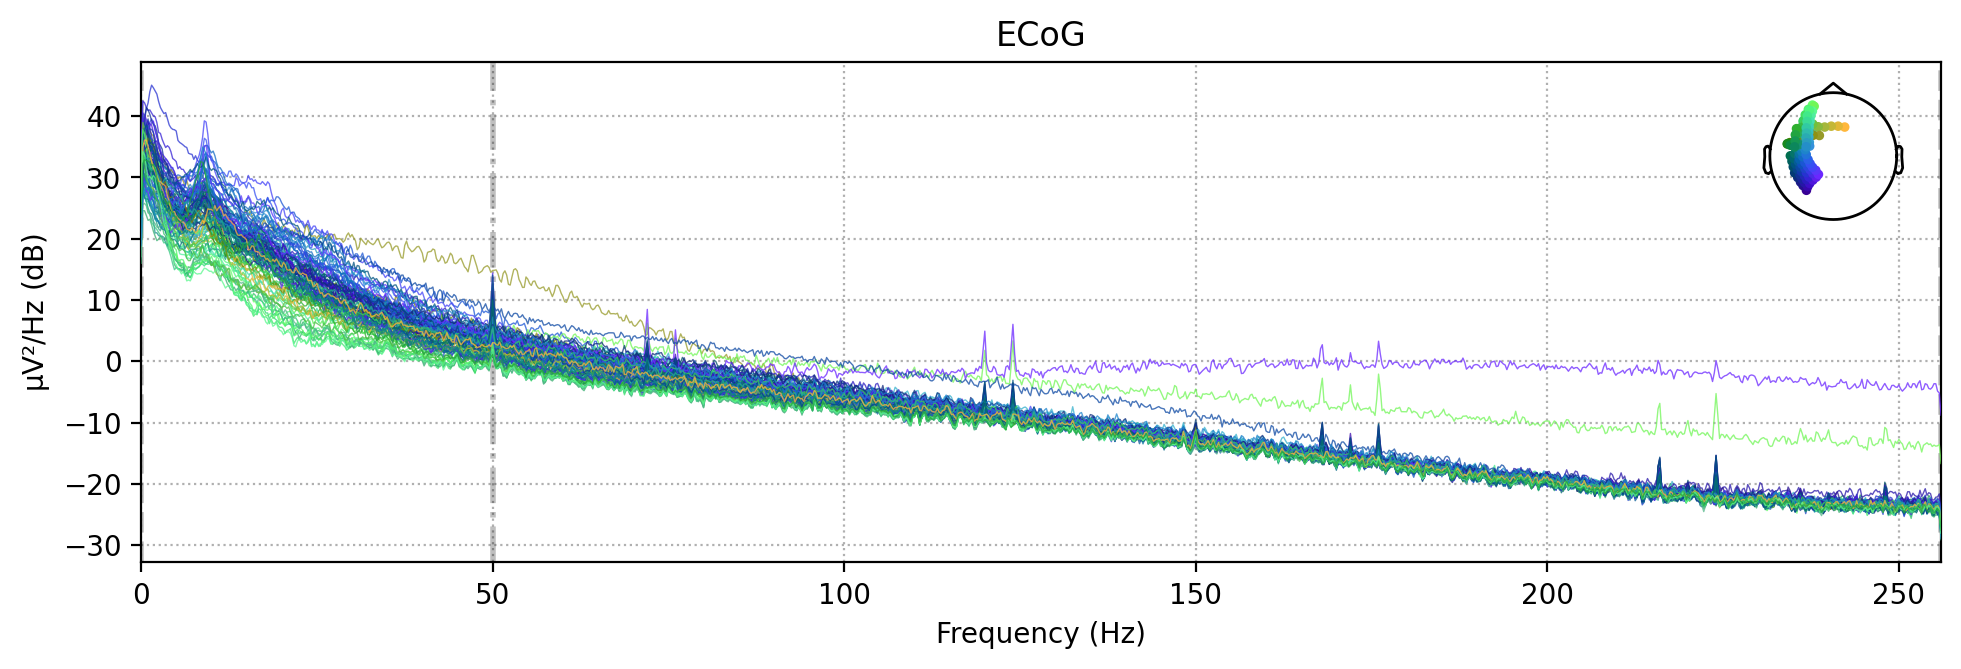

In [21]:
raw.compute_psd().plot(picks='data', exclude=[])

In [22]:
raw.compute_psd?

    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/3f/h3pnh73d18ldksmkrp_fvtk00000gn/T/ipykernel_47353/3903613333.py:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw.compute_psd(method='multitaper', fmin=1, fmax=150).plot()


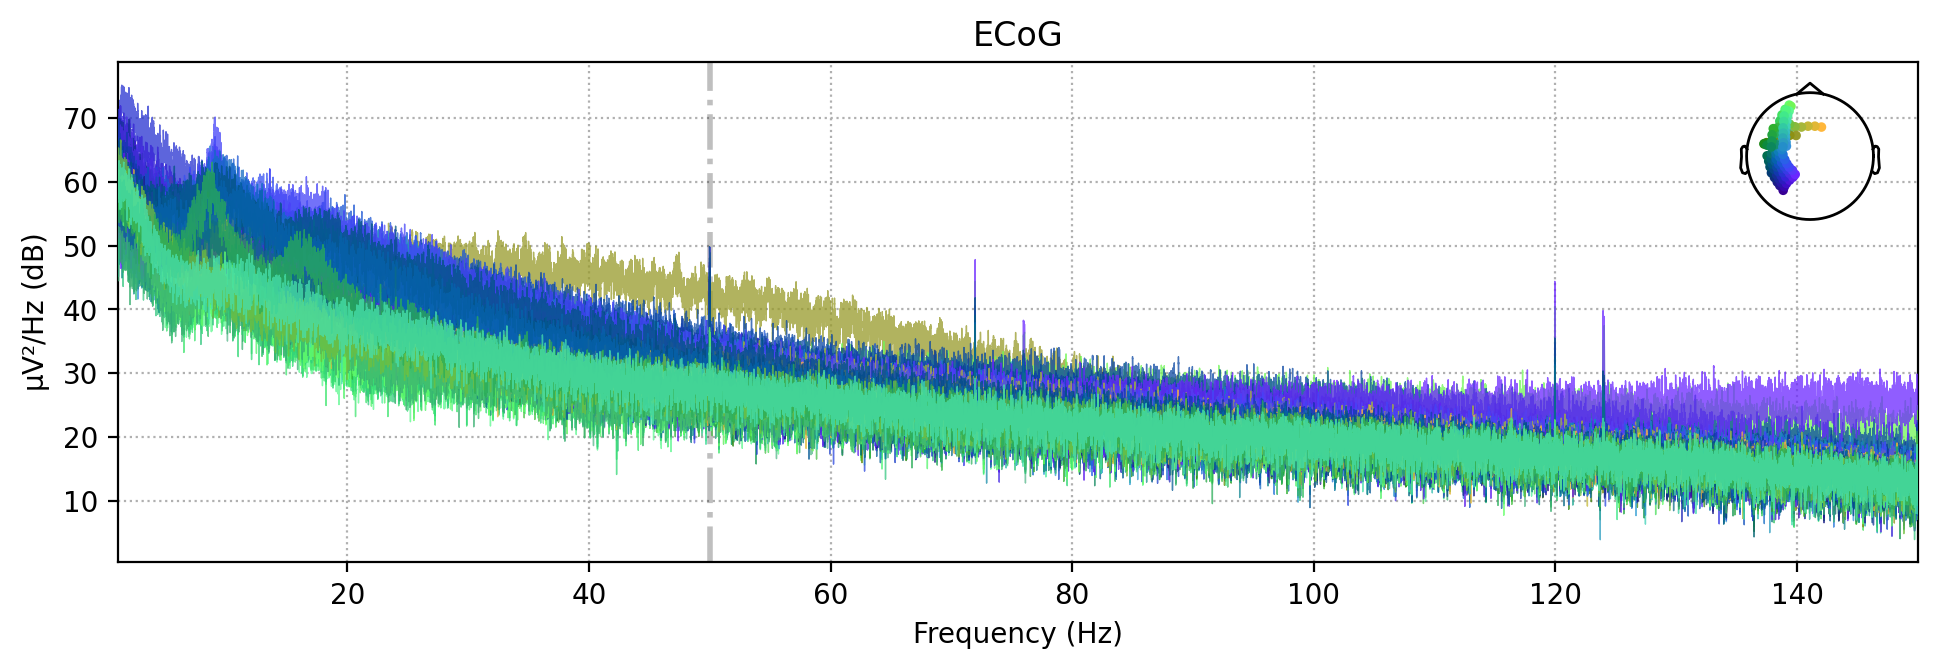

In [23]:
raw.compute_psd(method='multitaper', fmin=1, fmax=150).plot()

## Do the same without having loaded the metadata from BIDs

Here we will see the data with bad channels included, and with all the channel types marked as EEG.

In [24]:
raw_nobids.info

<Info | 7 non-empty values
 bads: []
 ch_names: P01, P02, P03, P04, P05, P06, P07, P08, P09, P10, P11, P12, P13, ...
 chs: 112 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 1900-01-01 00:00:00 UTC
 nchan: 112
 projs: []
 sfreq: 512.0 Hz
>

Effective window size : 4.000 (s)


/var/folders/3f/h3pnh73d18ldksmkrp_fvtk00000gn/T/ipykernel_47353/2138664497.py:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw_nobids.compute_psd().plot()
/var/folders/3f/h3pnh73d18ldksmkrp_fvtk00000gn/T/ipykernel_47353/2138664497.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_nobids.compute_psd().plot()


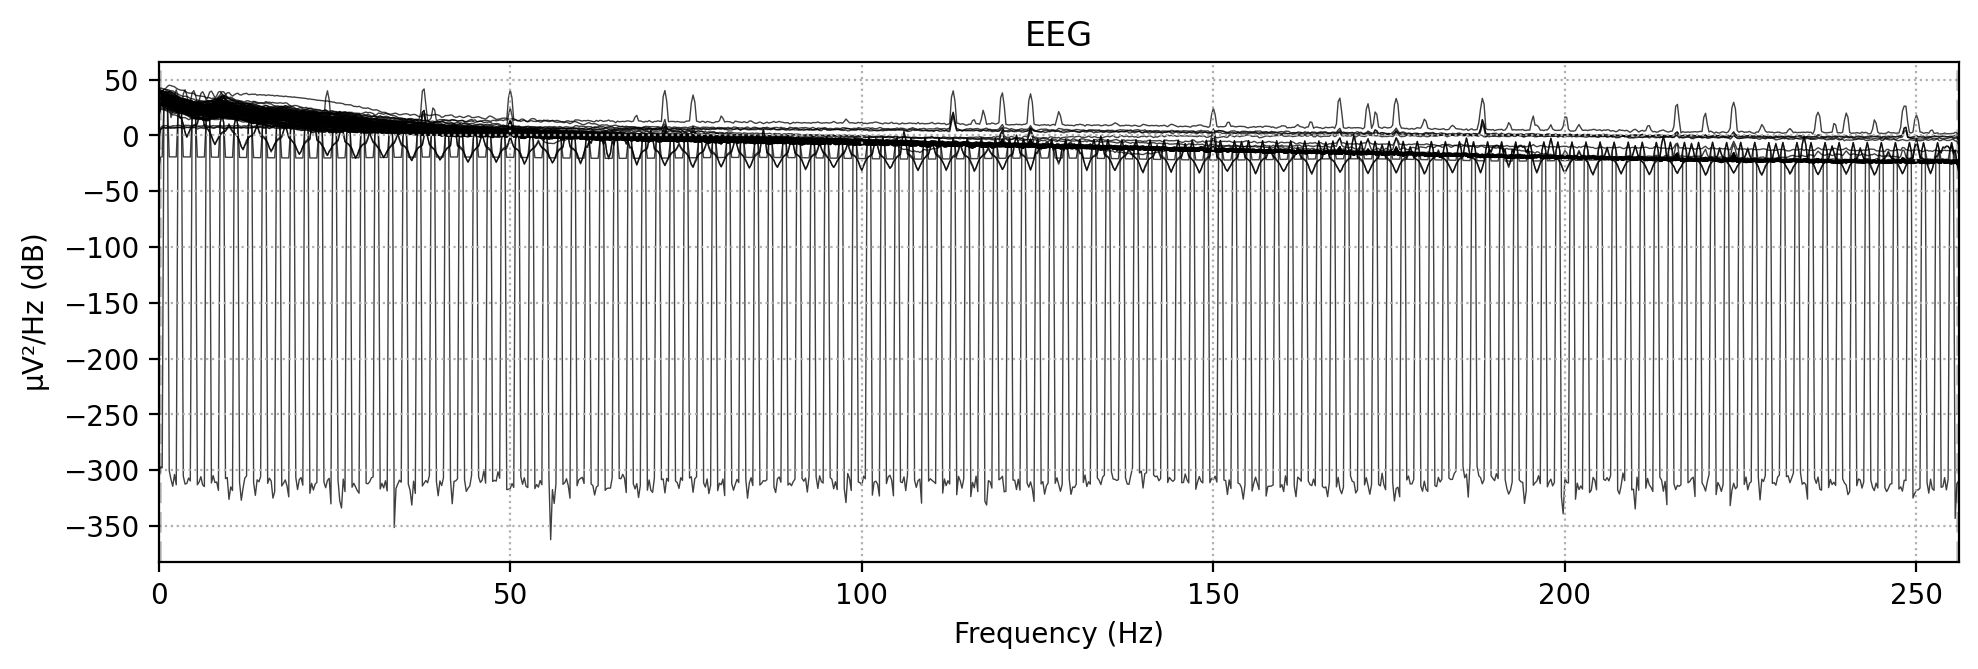

In [25]:
raw_nobids.compute_psd().plot()

In [68]:
# Plot the data, reject bad segments. Look for times where there
# are spike wave discharges (epileptiform artifacts) or large
# movement artifacts. Be selective, look out for blocks with a 
# ton of seizure activity
raw.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

Using pyopengl with version 3.1.6
Channels marked as bad:
['P48', 'MKR1+', 'T03']


In [27]:
# Plot the data, reject bad segments. Look for times where there
# are spike wave discharges (epileptiform artifacts) or large
# movement artifacts. Be selective, look out for blocks with a 
# ton of seizure activity
raw_nobids.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

Using pyopengl with version 3.1.6
Channels marked as bad:
none


## Referencing

Referencing or re-referencing your data should be done with some knowledge of your recording setup and what you wish to measure. You can read more about referencing [here (for EEG)](https://pressrelease.brainproducts.com/referencing/#:~:text=The%20reference%20influences%20the%20amplitude,affected%20by%20similar%20electrical%20activity.). Typically, experimenters will choose one of the following references:

1. Based on a single electrode in white matter (or relatively "quiet" electrode far away from your signals of interest. 
2. Based on the average of all electrodes or a block of electrodes (CAR or Common Average Reference). Note that the CAR is *not* a good idea if all of your electrodes are within a single functional area, as you will likely subtract out more signal than noise. 
3. Bipolar referencing, in which pairs of adjacent electrodes are subtracted to calculate more local signals. This is a bit more complicated but allows you to work with data in a single region without the drawbacks of the CAR.

In [28]:
# Example of single reference channel - this subtracts the signal from this channel
# from all other channels (including itself), so the reference will appear as a flat
# line after this step
raw_ref = raw.copy()
raw_ref.set_eeg_reference(ref_channels = ['P01'], )
raw_ref.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

ECoG channel type selected for re-referencing
Applying a custom ('ECoG',) reference.
Using pyopengl with version 3.1.6
Channels marked as bad:
['P48', 'MKR1+', 'T03']


In [29]:
# Example of common average reference. The common average reference subtracts the average
# signal across all *good* channels from every single channel. This is typically a good
# choice for removing noise across all channels (for example, sometimes EMG from chewing,
# some movement artifacts, electrical noise).
raw_ref_car = raw.copy()
raw_ref_car.set_eeg_reference(ref_channels = 'average')
raw_ref_car.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
Using pyopengl with version 3.1.6
Channels marked as bad:
['P48', 'MKR1+', 'T03']


## Bipolar reference

Bipolar referencing is a bit trickier and is not fully implemented here. You need to use knowledge of the physical locations of the electrodes to properly create the bipolar montage. For example, in the image below, we would need to use the knowledge of how the electrodes are placed in order to create the appropriate pairs for the anode and cathode.

![sub-06 electrode locations](sub-06_ses-iemu_acq-render_photo_ecog_left.jpeg)

In [47]:
# Example of bipolar reference. This would normally be done with some manual
# intervention of the specific channel pairs. Here we will 

import re  # regex

raw_ieeg = raw.copy()
raw_ieeg.pick_types(ecog=True)
ch_pairs = list(zip(raw_eeg.info['ch_names'][:-1],
                    raw_eeg.info['ch_names'][1:]))
anode = []
cathode = []
for pair in ch_pairs:
    ch1_dev = re.sub(r'\d+', '', pair[0])
    ch2_dev = re.sub(r'\d+', '', pair[1])
    if ch1_dev == ch2_dev:
        anode.append(pair[0])
        cathode.append(pair[1])

raw.load_data()
raw_ref_bip = mne.set_bipolar_reference(raw, anode=anode, cathode=cathode)
raw_ref_bip.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
ECoG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=96, n_times=203146
    Range : 0 ... 203145 =      0.000 ...   396.768 secs
Ready.
Added the following bipolar channels:
P01-P02, P02-P03, P03-P04, P04-P05, P05-P06, P06-P07, P07-P08, P08-P09, P09-P10, P10-P11, P11-P12, P12-P13, P13-P14, P14-P15, P15-P16, P16-P17, P17-P18, P18-P19, P19-P20, P20-P21, P21-P22, P22-P23, P23-P24, P24-P25, P25-P26, P26-P27, P27-P28, P28-P29, P29-P30, P30-P31, P31-P32, P32-P33, P33-P34, P34-P35, P35-P36, P36-P37, P37-P38, P38-P39, P39-P40, P40-P41, P41-P42, P42-P43, P43-P44, P44-P45, P45-P46, P46-P47, Fb49-Fb50, Fb50-Fb51, Fb51-Fb52, Fb52-Fb53, Fb53-Fb54, Fb54-Fb55, Fb55-Fb56, Fb56-Fb57, Fb57-Fb58, Fb58-Fb59, Fb59-Fb60, Fb60-Fb61, Fb61-Fb62, Fb62-Fb63, Fb63-Fb64, vT1-vT2, vT2-vT3, vT3-vT4, vT4-vT5, vT5-vT6, vT6-vT7, vT7-vT8, sT1-sT2, sT2-sT3, sT3-sT4, sT4-sT5, sT5-sT6, sT6-sT7, sT7-sT8, T01

# Calculate the high gamma transform of your data

Now we will take the raw, preprocessed data, and convert to high gamma analytic amplitude for further analysis. The high gamma analytic amplitude is used in many papers as a proxy for multi-unit firing (see [Ray and Maunsell, PLoS Biology 2011](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000610)).

This particular version of the high gamma transform uses the same procedure as used in [Hamilton et al. 2018](cell.com/current-biology/pdf/S0960-9822(18)30461-5.pdf) and [Hamilton et al. 2021](https://www.cell.com/cell/pdf/S0092-8674(21)00878-3.pdf). The basic idea is to take 8 bands within the 70-150 Hz range, calculate the Hilbert transform, then take the analytic amplitude of that signal and average across the 8 bands. This form of averaging results in higher SNR than one band between 70-150 Hz. 

In [48]:
# Get the high gamma data
# Generally, do a CAR if you have widespread coverage over multiple
# areas (not just one sensory area)
# If you have limited coverage, you may choose to do no CAR or choose
# to reference to one specific channel.
hgdat = transformData(raw_ieeg, ieeg_dir, band='high_gamma', notch=True, CAR=True,
                      car_chans='average', log_transform=True, do_zscore=True,
                      hg_fs=100, notch_freqs=[60,120,180], overwrite=False,
                      ch_types='ecog', save=False)


Doing notch filter
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:    0.3s finished


Using pyopengl with version 3.1.6
Channels marked as bad:
none
Doing CAR on
average
ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
Using pyopengl with version 3.1.6
Channels marked as bad:
none
Getting frequency bands for Hilbert transform
Getting high_gamma band data
Getting the raw data array


applying Hilbert transform...:   0%|                                                                                                             | 0/8 [00:00<?, ?it/s]/Users/liberty/Documents/Austin/code/nh23-curriculum/hamilton-ieeg-preprocessing/ecog_preproc_utils.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  hilbdat[ch,:] = applyHilbertTransform(raw_data[ch,:], raw.info['sfreq'], ct, sd)
applying Hilbert transform...:  12%|████████████▋                                                                                        | 1/8 [00:02<00:16,  2.30s/it]

Taking log transform of high gamma



applying Hilbert transform...:  25%|█████████████████████████▎                                                                           | 2/8 [00:04<00:13,  2.31s/it]

Taking log transform of high gamma



applying Hilbert transform...:  38%|█████████████████████████████████████▉                                                               | 3/8 [00:06<00:11,  2.31s/it]

Taking log transform of high gamma



applying Hilbert transform...:  50%|██████████████████████████████████████████████████▌                                                  | 4/8 [00:09<00:09,  2.30s/it]

Taking log transform of high gamma



applying Hilbert transform...:  62%|███████████████████████████████████████████████████████████████▏                                     | 5/8 [00:11<00:06,  2.32s/it]

Taking log transform of high gamma



applying Hilbert transform...:  75%|███████████████████████████████████████████████████████████████████████████▊                         | 6/8 [00:13<00:04,  2.33s/it]

Taking log transform of high gamma



applying Hilbert transform...:  88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 7/8 [00:16<00:02,  2.32s/it]

Taking log transform of high gamma


applying Hilbert transform...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.32s/it]

Taking log transform of high gamma


Taking the mean across 8 bands
Z-scoring signal
Creating RawArray with float64 data, n_channels=102, n_times=203146
    Range : 0 ... 203145 =      0.000 ...   396.768 secs
Ready.
Using pyopengl with version 3.1.6
Channels marked as bad:
none


# Plotting evoked data

Now that we have some preprocessed data, let's plot the differences between experimental conditions. To do this, we will need the events timings, which are included in the `events.tsv` file. In this case, the events correspond to blocks of music and speech.

## Loading events

Now we will load events from the .tsv file to plot evoked responses to music and speech events. First I'll show you how to do this by creating an MNE events array, next I'll show you how to derive them from the annotations. This first method could also be used with non-BIDS datasets if you have the onset and duration and trial information.

In [53]:
event_file = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_run-{run}_events.tsv'
event_df = pd.read_csv(event_file, delimiter='\t')

In [54]:
event_df

,onset,duration,trial_type,value
0,5.281,0.024,start task,9
1,5.305,29.984,music,2
2,35.289,30.002,speech,1
3,65.291,30.004,music,2
4,95.295,30.002,speech,1
5,125.297,30.004,music,2
6,155.301,30.002,speech,1
7,185.303,30.004,music,2
8,215.307,30.002,speech,1
9,245.309,30.003,music,2


## Convert event times to samples

Now these event times are in seconds, not samples, so we have to convert them for use with MNE python's epochs constructor. Let's do that here. 

In [55]:
onset_samp = [int(onset*hgdat.info['sfreq']) for onset in event_df.onset]
dur_samp = [int(dur*hgdat.info['sfreq']) for dur in event_df.duration]
ev_id = [int(e*hgdat.info['sfreq']) for e in event_df.value]

eve = list(zip(onset_samp, dur_samp, ev_id))
print(eve)

[(528, 2, 900), (530, 2998, 200), (3528, 3000, 100), (6529, 3000, 200), (9529, 3000, 100), (12529, 3000, 200), (15530, 3000, 100), (18530, 3000, 200), (21530, 3000, 100), (24530, 3000, 200), (27531, 3000, 100), (30531, 3000, 200), (33531, 3000, 100), (36532, 3001, 200), (39533, 0, 400)]


## Another way...

So actually, because we already had these particular events as annotations, we could have also done this a simpler way, but the method above also works for other events that are stored in tsv files without becoming annotations.

In [56]:
events = mne.events_from_annotations(hgdat, event_id='auto')

Used Annotations descriptions: ['end task', 'music', 'speech', 'start task']


In [57]:
events

(array([[  528,     0,     4],
        [  530,     0,     2],
        [ 3529,     0,     3],
        [ 6529,     0,     2],
        [ 9530,     0,     3],
        [12530,     0,     2],
        [15530,     0,     3],
        [18530,     0,     2],
        [21531,     0,     3],
        [24531,     0,     2],
        [27531,     0,     3],
        [30532,     0,     2],
        [33532,     0,     3],
        [36532,     0,     2],
        [39534,     0,     1]]),
 {'end task': 1, 'music': 2, 'speech': 3, 'start task': 4})

## Create an epochs object

Now if we want to plot our data by epoch type, we can use the mne Epochs class. This allows us to parse our data according to these events and plot evoked activity.

In [58]:
epochs = mne.Epochs(hgdat, events=events[0], tmin=-0.2, tmax=5.0, event_id=[3])

Not setting metadata
6 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [59]:
# Here we will just plot the average
epochs.plot_image(combine='mean')

Using data from preloaded Raw for 6 events and 521 original time points ...
0 bad epochs dropped
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


[<Figure size 1280x960 with 3 Axes>]

In [67]:
# What about plotting a particular electrode?
epochs.plot_image(picks=[hgdat.info['ch_names'][13]])

Using data from preloaded Raw for 6 events and 521 original time points ...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


/var/folders/3f/h3pnh73d18ldksmkrp_fvtk00000gn/T/ipykernel_47353/303827018.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=[hgdat.info['ch_names'][13]])


[<Figure size 1280x960 with 3 Axes>]

In [65]:
def plot_epochs(epochs, nchans, ch_names, color='b', label='spkr', show=True, vmin_max=None):
    eps = epochs.get_data()
    emax = np.abs(epochs.average().data).max()
    nrows = int(np.floor(np.sqrt(nchans)))
    ncols = int(np.ceil(nchans/nrows))
    for ch in np.arange(nchans):
        plt.subplot(nrows, ncols, ch+1)
        erp = eps[:,ch,:].mean(0)
        erpstd = eps[:,ch,:].std(0)/np.sqrt(eps.shape[0])
        ybottom = erp - erpstd
        ytop = erp + erpstd

        plt.fill_between(epochs.times, ybottom.ravel(), ytop.ravel(),
                         alpha=0.5, color=color)
        plt.plot(epochs.times, erp, color=color, label=label)
        plt.axvline([0], color='k', linewidth=0.5)
        plt.axhline([0], color='k', linewidth=0.5)
        if vmin_max is None:
            plt.gca().set_ylim([-emax*1.5, emax*1.5])
        else:
            plt.gca().set_ylim([vmin_max[0], vmin_max[1]])
        if ch != 0:
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        else:
            plt.ylabel('Z-score')

        plt.text(0.5, 0.25, ch_names[ch], 
            horizontalalignment='center', verticalalignment='center',
            transform=plt.gca().transAxes, fontsize=8)
    plt.gca().set_xticks([epochs.tmin, 0, epochs.tmax])
    plt.xlabel('Time (s)')
    plt.legend()
    #plt.tight_layout()
    if show:
        plt.show()

In [66]:
plot_epochs(epochs, len(hgdat.info['ch_names']), hgdat.info['ch_names'], label='speech')

Using data from preloaded Raw for 6 events and 521 original time points ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


## Using stimulus annotations

In addition to the "speech" vs "music" gross-level annotations, the researchers have provided information about the onset and offset of different types of information in the sound as well as the video. You can look in the `stimuli` folder to see what types of annotations are provided, but in general, these include word-level, syllable-level, sentence-level, and specific talkers as well as some other information.

In [144]:
# Get the word times
annotation = 'words'
word_times = pd.read_csv(f'{parent_dir}/stimuli/annotations/sound/sound_annotation_{annotation}.tsv', delimiter='\t')
word_times

,item,onset,offset
0,pippi,30.736,31.106
1,wil,31.590,31.704
2,je,31.704,31.818
3,mee,31.818,31.966
4,ontbijten,31.966,32.490
...,...,...,...
441,komen,356.895,357.190
442,brengen,357.190,357.479
443,met,357.479,357.659
444,een,357.659,357.697


In [145]:
start_sample = events[0][events[0][:,2] == events[1]['start task'],0][0]

In [146]:
word_events = []
for idx, row in word_times.iterrows():
    onset_sample = int(row['onset']*hgdat.info['sfreq'])  # convert time to samples
    offset_sample = int(row['offset']*hgdat.info['sfreq'])  # convert time to samples
    duration_sample = offset_sample - onset_sample
    onset_sample+= start_sample  # need to shift by the actual starting time of the task
    
    word_events.append([onset_sample, duration_sample, 1])


In [147]:
epochs_words = mne.Epochs(hgdat, events=word_events, tmin=-0.2, tmax=1.0)

Not setting metadata
446 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [148]:
epochs_words.plot_image(combine='mean')

Using data from preloaded Raw for 446 events and 121 original time points ...
0 bad epochs dropped
Not setting metadata
446 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


[<Figure size 1280x960 with 3 Axes>]

In [107]:
plot_epochs(epochs_words, len(hgdat.info['ch_names']), hgdat.info['ch_names'], label='words')

Using data from preloaded Raw for 446 events and 121 original time points ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [109]:
epochs_words.plot_image(picks=['P18'])

Using data from preloaded Raw for 446 events and 121 original time points ...
Not setting metadata
446 matching events found
No baseline correction applied
0 projection items activated


/var/folders/3f/h3pnh73d18ldksmkrp_fvtk00000gn/T/ipykernel_47353/3367921786.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_words.plot_image(picks=['P18'])


[<Figure size 1280x960 with 3 Axes>]

In [117]:
epochs_array = epochs_words.get_data()
print(f'{epochs_array.shape[0]} {annotation} events for\
  {epochs_array.shape[1]} channels and {epochs_array.shape[2]} time points')

Using data from preloaded Raw for 446 events and 121 original time points ...
446 words events for  102 channels and 121 time points


In [143]:
# Use matplotlib to show the average across all epochs
plt.imshow(epochs_array.mean(0))
plt.xlabel('Time')
plt.ylabel('Channel')
plt.gca().set_xticks([0, 
                      -int(epochs_words.tmin*epochs_words.info['sfreq']), 
                      int((epochs_words.tmax - epochs_words.tmin)*epochs_words.info['sfreq'])])
plt.gca().set_xticklabels([epochs_words.tmin, 0, epochs_words.tmax])
plt.axvline(-int(epochs_words.tmin*epochs_words.info['sfreq']), color='w', linestyle='--')

In [139]:
epochs_words.info['sfreq']

100.0